In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from transformers.optimization import AdamW
from transformers import Trainer, TrainingArguments

## Memory statistics. I had to be careful with cuda memory 
def mem_stats():
    t = torch.cuda.get_device_properties(0).total_memory / 1024**3
    r = torch.cuda.memory_reserved(0) / 1024**3
    a = torch.cuda.memory_allocated(0) / 1024**3
    print(f"Total Memory: {t:.2f} GB\n"
          f"Reserved Memory: {r:.2f} GB ({(100*(r/t)):.2f}%)\n"
          f"Remaining Memory: {t-r:.2f} GB ({(100*(t-r)/t):.2f}%)\n"
          f"---------------------------------\n"
          f"Allocated Memory: {a:.2f} GB ({(100*(a/t)):.2f}%)\n"
          f"Percent of Reserved Allocated: {(100*(a+1e-9)/(r+1e-9)):.2f}%\n")


In [3]:
from datasets import load_dataset

dataset = load_dataset("amazon_us_reviews", "Digital_Video_Games_v1_00")

Found cached dataset amazon_us_reviews (/home/ec2-user/.cache/huggingface/datasets/amazon_us_reviews/Digital_Video_Games_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
train_dataset = dataset["train"][:len(dataset["train"])//25]
test_dataset = dataset["train"][len(dataset["train"])//25:2*len(dataset["train"])//25]

In [ ]:
training_dataset = train_dataset['review_body']
testing_dataset = test_dataset['review_body']

In [ ]:
N = 2
epochs = 4
bs = 2
learn = 5e-5
mod_size = "160m"

# DataLoaders

In [6]:
# model = GPTNeoXForCausalLM.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped")
tokenizer = AutoTokenizer.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped")
mem_stats()

Total Memory: 15.77 GB
Reserved Memory: 0.00 GB (0.00%)
Remaining Memory: 15.77 GB (100.00%)
---------------------------------
Allocated Memory: 0.00 GB (0.00%)
Percent of Reserved Allocated: 100.00%



In [7]:
def collate_fn(batch):
    global models
    tokens = [tokenizer.encode(example, return_tensors="pt", truncation=True,max_length=models[0].config.max_position_embeddings) for example in batch]
    max_length = max([t.size(1) for t in tokens])
    tokens_padded = [torch.cat([t, t.new_zeros(t.size(0), max_length - t.size(1))], dim=1) for t in tokens]
    tokens_padded = torch.cat(tokens_padded, dim=0)
    return {
        "input_ids":tokens_padded,
        "labels":tokens_padded,
        "attention_mask": torch.tensor(tokens_padded>0,dtype=int)
    }

In [8]:
def arr_split(chunks, N):
  if N % 2 != 0:
    print("Need even N!")
    return []
  lists = [[] for i in range(N)]
  
  for i in range(N):
    for j in range(i, int(i + N/2)):
      lists[i] += chunks[j % N]
  
  return lists

In [9]:
train_chunks = [training_dataset[i * len(training_dataset)//N : (i+1) * len(training_dataset) // N] for i in range(N)]
test_chunks = [testing_dataset[i * len(testing_dataset)//N : (i+1) * len(testing_dataset) // N] for i in range(N)]

In [10]:
train_arr = arr_split(train_chunks, N)
test_arr = arr_split(test_chunks, N)

In [11]:
# 80% overlap
len(set(train_arr[0]).intersection(train_arr[1]))

116

In [12]:
# train_dls = [DataLoader(train_arr[i], batch_size = bs, collate_fn=collate_fn, shuffle = True) for i in range(N)]
# test_dls = [DataLoader(test_arr[i], batch_size = bs, collate_fn=collate_fn, shuffle = True) for i in range(N)]


# Shadow Models

In [13]:
# Set the device to use
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [14]:
models = [GPTNeoXForCausalLM.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped").to(device) for i in range(N)]
mem_stats()

Total Memory: 15.77 GB
Reserved Memory: 0.60 GB (3.80%)
Remaining Memory: 15.17 GB (96.20%)
---------------------------------
Allocated Memory: 0.58 GB (3.66%)
Percent of Reserved Allocated: 96.31%



In [66]:
def train(model, train_dataset, val_dataset, collate_fn, batch_size, epochs):
  model = model.to(device)
  model.config.use_cache = False
  training_args = TrainingArguments(output_dir="fine-tuning",
                                    do_train=True,
                                    do_eval=True,
                                    num_train_epochs=epochs,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    evaluation_strategy="epoch",
                                    # logging_strategy="epoch",
                                    # save_strategy="epoch",
                                    gradient_accumulation_steps=1,
                                    gradient_checkpointing=False,
                                    # fp16=True,
                                    optim="adafactor",
                                    )
  trainer = Trainer(model=model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=tokenizer,
                    data_collator=collate_fn,
                    # callbacks = [CustomLoggingCallback()]
                  )
  trainer.train()
  return model

In [67]:
for i, m in enumerate(models):
  print(f"Model #{i}")
  m.to(device)
  m = train(m, train_arr[i], test_arr[i], collate_fn, bs, epochs)
  # train(m, train_dls[i], epochs)
  m.to('cpu')
  torch.cuda.empty_cache()

  

PyTorch: setting up devices


Model #0
PyTorch: setting up devices


The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** Running training *****


***** Running training *****


  Num examples = 2,908


  Num examples = 2,908


  Num Epochs = 4


  Num Epochs = 4


  Instantaneous batch size per device = 4


  Instantaneous batch size per device = 4


  Total train batch size (w. parallel, distributed & accumulation) = 4


  Total train batch size (w. parallel, distributed & accumulation) = 4


  Gradient Accumulation steps = 1


  Gradient Accumulation steps = 1


  Total optimization steps = 2,908


  Total optimization steps = 2,908


  Number of trainable parameters = 70,426,624


  Number of trainable parameters = 70,426,624


/tmp/ipykernel_11868/1920141103.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(tokens_padded>0,dtype=int)


Epoch,Training Loss,Validation Loss


Saving model checkpoint to fine-tuning/checkpoint-500


Saving model checkpoint to fine-tuning/checkpoint-500


Configuration saved in fine-tuning/checkpoint-500/config.json


Configuration saved in fine-tuning/checkpoint-500/config.json


Configuration saved in fine-tuning/checkpoint-500/generation_config.json


Configuration saved in fine-tuning/checkpoint-500/generation_config.json


Model weights saved in fine-tuning/checkpoint-500/pytorch_model.bin


Model weights saved in fine-tuning/checkpoint-500/pytorch_model.bin


tokenizer config file saved in fine-tuning/checkpoint-500/tokenizer_config.json


tokenizer config file saved in fine-tuning/checkpoint-500/tokenizer_config.json


Special tokens file saved in fine-tuning/checkpoint-500/special_tokens_map.json


Special tokens file saved in fine-tuning/checkpoint-500/special_tokens_map.json
Step: 727, Loss: 1.134600, Batch size: 4
***** Running Evaluation *****


  Num examples = 2908


  Num examples = 2908


  Batch size = 4


  Batch size = 4


KeyboardInterrupt: 

# Save Models

In [ ]:
for i, model in enumerate(models):
  model_save_name = f'model_{i}.pt'
  path = f"/content/gdrive/My Drive/{model_save_name}" 
  model.save_pretrained(path)

# Load Models
(If not saving them)

In [ ]:
import math
from torch.nn import CrossEntropyLoss

def compute_ce_loss(model, tokenizer, string):
  input_ids = tokenizer.encode(string, return_tensors="pt")

  with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits

  loss_fn = CrossEntropyLoss()
  input_len = input_ids.shape[-1] - 1
  input_ids_without_first_token = input_ids[:, 1:]
  logits_without_last_token = logits[:, :-1, :]
  loss = loss_fn(logits_without_last_token.view(-1, logits.size(-1)), input_ids_without_first_token.view(-1))
  return loss

def compute_confidence(ce_loss):
  conf = math.exp(-1 * ce_loss)
  return math.log(conf / (1-conf))

In [ ]:
# Normality Testing
# "empirically" normally dist. 

new_model = GPTNeoXForCausalLM.from_pretrained("/content/gdrive/My Drive/model_10.pt", local_files_only=True)

In [ ]:
# Likelihood ratio attacks
default_tokenizer = AutoTokenizer.from_pretrained( "EleutherAI/pythia-160m-deduped")
string = "Hello! I love bitcoin and artificial intelligence. Fentanyl and oxycodon, along with frequent invokations of JFK, are titivating"

In [ ]:
new_model.eval()
ce_loss = compute_ce_loss(new_model, default_tokenizer, string)
conf = compute_confidence(ce_loss)
print(f"Model Output: {ce_loss} {conf}")

Model Output: 8.479928970336914 -8.479721355338926


# Viz

In [ ]:
def get_in_models(chunk_no, N):
  """
  Returns a list of models that should be used for inference for a given chunk
  """
  ins = []
  outs = []
  for i in range(N):
    lower = i
    upper = int(i+N/2)
    innit = False
    for j in range(lower, upper):
      if chunk_no == j % N:
        innit = True
    if innit:
      ins.append(i)
    else:
      outs.append(i)
  return (ins, outs)

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SubsetRandomSampler
import random

# Define your 30 sets of 12 numbers
chunk = []
chunkno = 1
ins, outs = get_in_models(chunkno, N)

inconfidences = [[] for i in range(30)]
outconfidences = [[] for i in range(30)]

# Get In Confidences
for i, b in enumerate(random.sample(train_chunks[chunkno], 30)):
  print(f"{i}")
  for index in ins:
    # try:
    #   ce_loss = compute_ce_loss(models[index], default_tokenizer, b)
    #   conf = compute_confidence(ce_loss)
    #   inconfidences[i].append(conf)
    #   print(f" - {index}")
    # except:
    ce_loss = compute_ce_loss(models[index], default_tokenizer, b[:2048])
    conf = compute_confidence(ce_loss)
    inconfidences[i].append(conf)
    print(f" -- {index}")

  for index in outs:
    # try:
    #   ce_loss = compute_ce_loss(models[index], default_tokenizer, b)
    #   conf = compute_confidence(ce_loss)
    #   outconfidences[i].append(conf)
    #   print(f" - {index}")
    # except:
    ce_loss = compute_ce_loss(models[index], default_tokenizer, b[:2048])
    conf = compute_confidence(ce_loss)
    inconfidences[i].append(conf)
    print(f" -- {index}")


0
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
1
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
2
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
3
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
4
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
5
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
6
 -- 0
 -- 1
 -- 8
 -- 9
 -- 10
 -- 11
 -- 2
 -- 3
 -- 4
 -- 5
 -- 6
 -- 7
7
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
8
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
9
 -- 0
 -- 1
 -- 8
 -- 9
 -- 10
 -- 11
 -- 2
 -- 3
 -- 4
 -- 5
 -- 6
 -- 7
10
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
11
 -- 0
 -- 1
 -- 8
 -- 9
 -- 10
 -- 11
 -- 2
 -- 3
 -- 4
 -- 5
 -- 6
 -- 7
12
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
13
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7
14
 - 0
 - 1
 - 8
 - 9
 - 10
 - 11
 - 2
 - 3
 - 4
 - 5
 - 6
 - 7

In [ ]:
outconfidences

[[-5.008516755007468,
  -4.642556059993249,
  -5.149636507841942,
  -4.276712242079647,
  -4.507794429312644,
  -4.097030041246043],
 [-4.74170363680411,
  -5.058258242172654,
  -5.761728480704437,
  -5.039497155001716,
  -5.090347651713408,
  -4.9854503598342745],
 [-4.374619294362083,
  -4.643322494629266,
  -4.964574245900876,
  -4.493790475908574,
  -4.459352276924914,
  -4.276808933933826],
 [-5.784305678332781,
  -6.295394314033934,
  -6.069884850499335,
  -5.349111634769479,
  -5.325273934629069,
  -5.312268218615236],
 [-4.892034183756799,
  -5.7639685256244535,
  -5.756262953731349,
  -5.0260116167528635,
  -4.471346156746507,
  -4.748248858810809],
 [-3.0781388524512114,
  -3.29038085935437,
  -3.6509506452495617,
  -2.9696100838939143,
  -3.091816396546448,
  -2.891121151347303],
 [],
 [-3.5829961526683287,
  -4.040697899293972,
  -4.173824744739535,
  -3.656241927967994,
  -3.6080785837244727,
  -3.723221700878654],
 [-5.499891739085198,
  -6.255186724910647,
  -7.310384462

# Visualizing Figure

In [ ]:
import copy
inconf_copy = copy.deepcopy(inconfidences)
outconf_copy = copy.deepcopy(outconfidences)

inconf = []
outconf = []

for i in range(len(inconf_copy)):
  if len(inconf_copy[i]) == 0 or len(outconf_copy[i]) == 0:
    continue
  else:
    inconf.append(inconf_copy[i])
    outconf.append(outconf_copy[i])

inconf = inconf[:20]
outconf = outconf[:20]

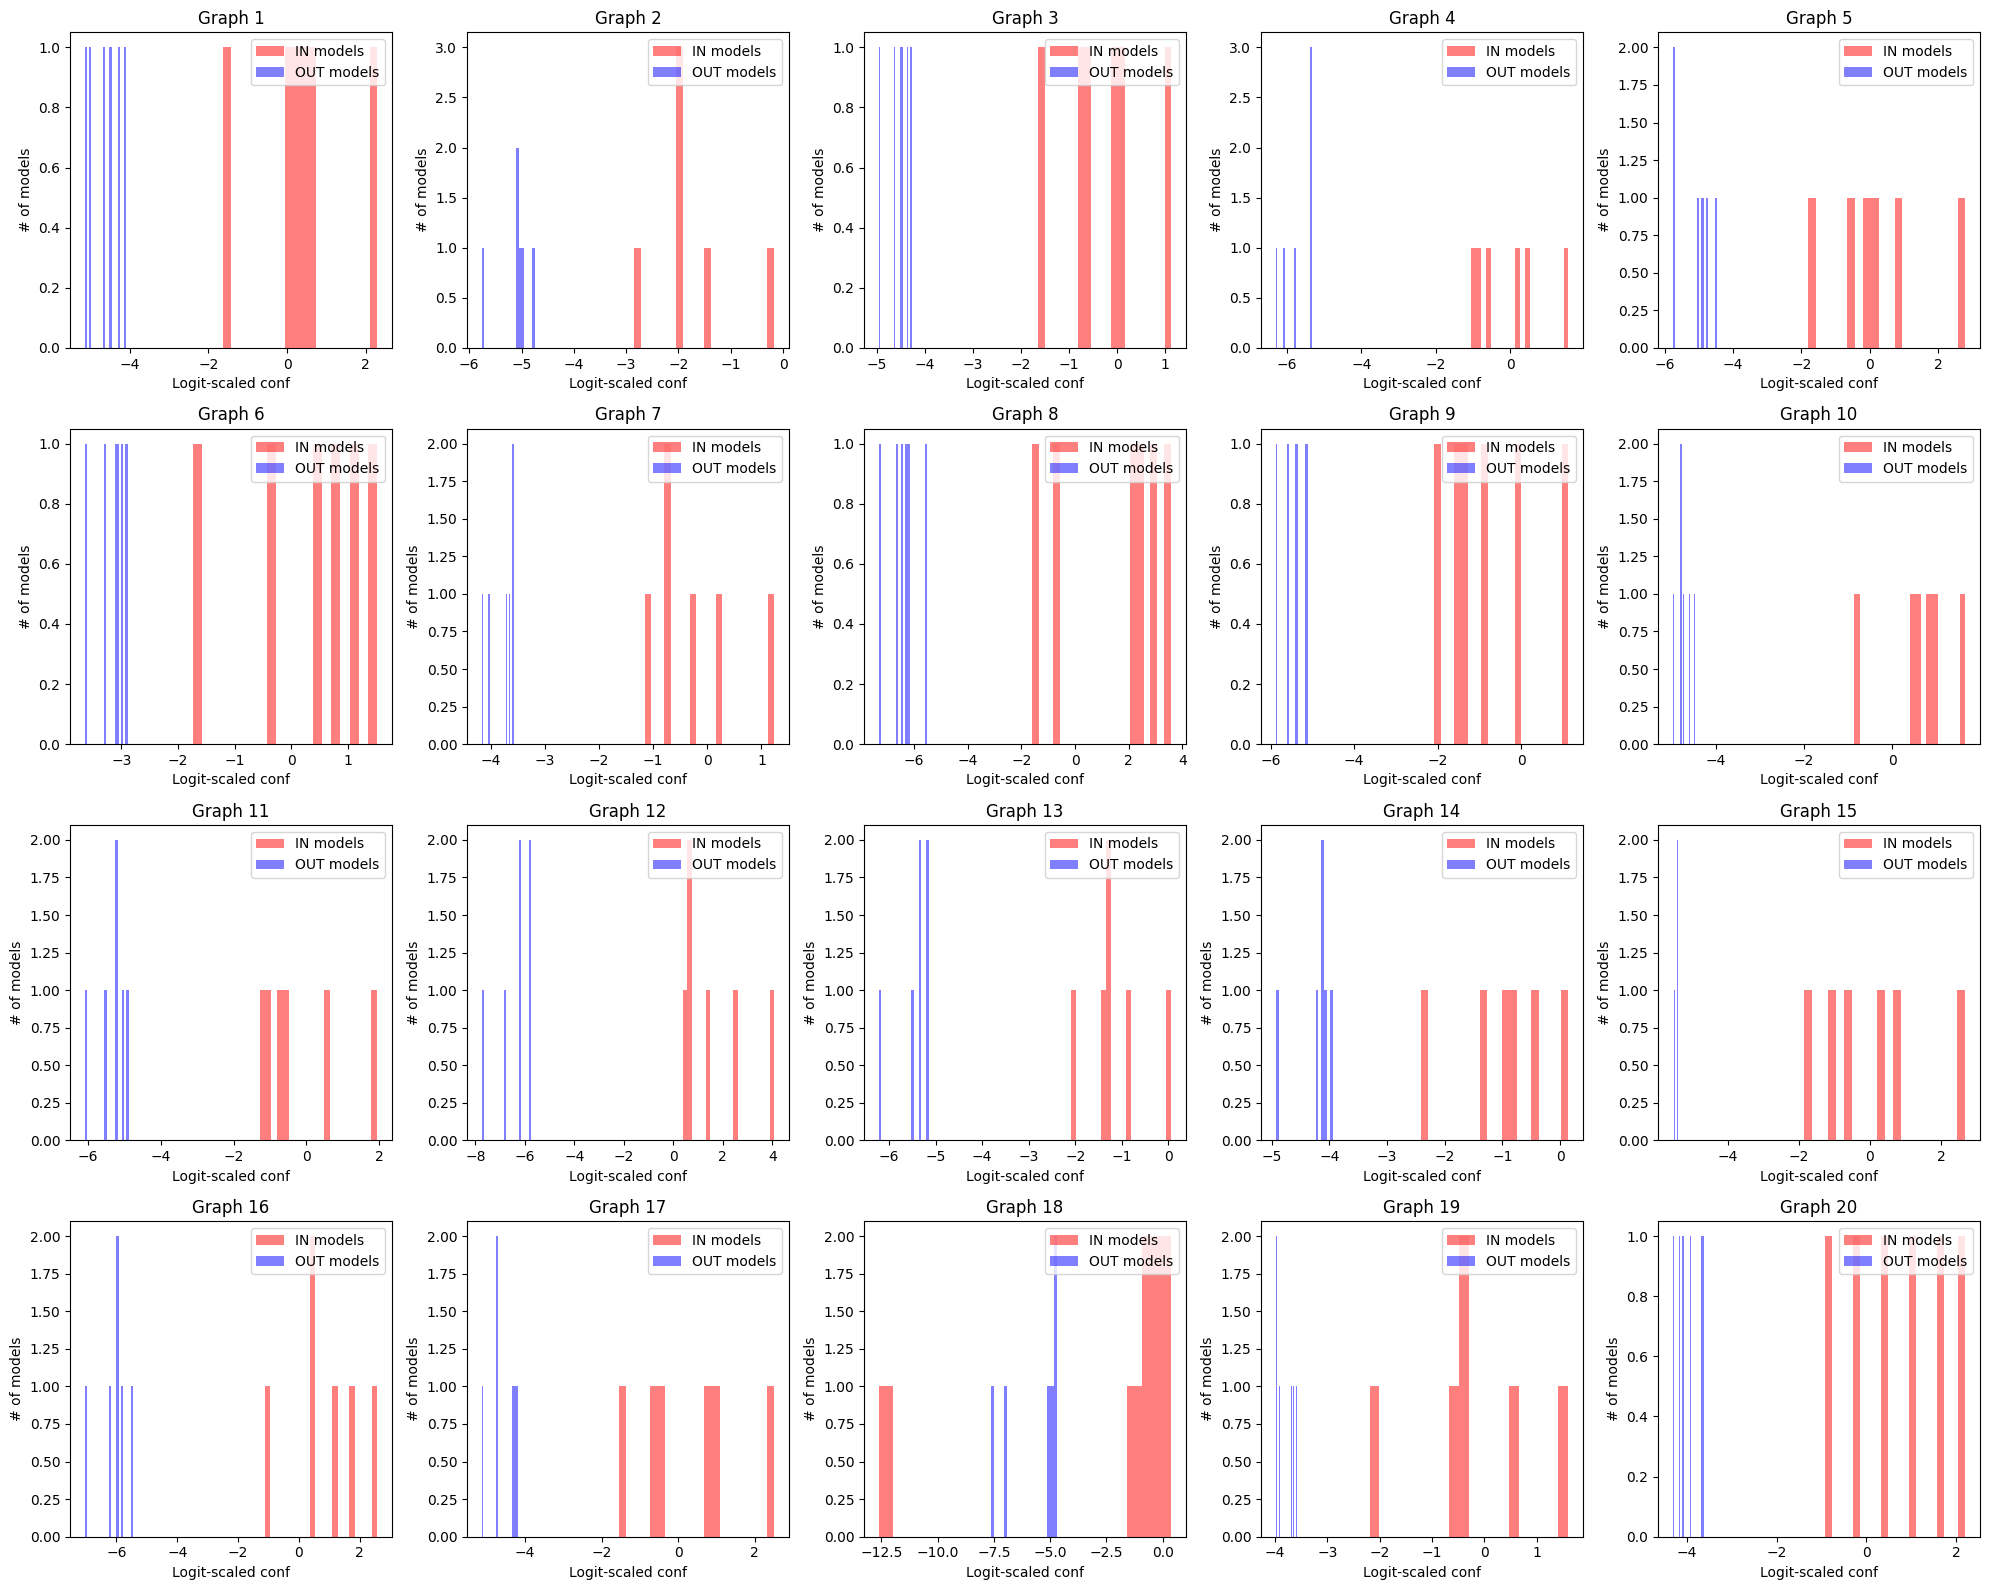

In [ ]:
# Create a figure with a specified size
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20, 16))
num_bins = 20

# Loop through the 30 lists in A and B
for i in range(20):
    # Determine the position of the subplot in the 10x3 grid
    row = i // 5
    col = i % 5

    # Create the histograms for A[i] and B[i]
    axs[row, col].hist(inconf[i], bins=num_bins, color='red', alpha=0.5, label='IN models')
    axs[row, col].hist(outconf[i], bins=num_bins, color='blue', alpha=0.5, label='OUT models')
    
    # Set the title for the subplot
    axs[row, col].set_title(f'Graph {i+1}')
    
    # Add a legend to the subplot
    axs[row, col].legend(loc='upper right')
    axs[row, col].set_xlabel('Logit-scaled conf')
    axs[row, col].set_ylabel('# of models')

# Adjust the layout to avoid overlapping labels
plt.tight_layout()

# Save the figure as a file
plt.savefig('histograms.png')

# Display the figure
plt.show()



